### Pré-processamento

In [1]:
import os
from PIL import Image

In [4]:
dirs = ['data/teste/bacterias/','data/treino/bacterias/','data/teste/bacterias/','data/treino/fungos/','data/teste/bacterias/','data/teste/fungos/']

for input_dir in dirs:
    os.makedirs(input_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpeg', '.bmp', '.gif', '.tif', '.webp')):
            img_path = os.path.join(input_dir, filename)
            img = Image.open(img_path)
            
            if img.mode in ("RGBA", "P", "L"):
                img = img.convert("RGB")
            
            base_filename = os.path.splitext(filename)[0]
            output_path = os.path.join(input_dir, base_filename + '.jpg')            
            img.save(output_path, 'JPEG')

for input_dir in dirs:
    for filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, filename)
        if not filename.lower().endswith('.jpg'):
            os.remove(img_path)

### Classificação

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
from skimage.filters import sobel

In [8]:
SIZE = 128
train_images = []
train_labels = [] 

for directory_path in glob.glob("data/treino/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print('train', label, img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Optional step. Change BGR to RGB
        train_images.append(img)
        train_labels.append(label)

print('train_labels', train_labels)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

bacterias
train bacterias data/treino\bacterias\002.jpg
train bacterias data/treino\bacterias\003.jpg
train bacterias data/treino\bacterias\004.jpg
train bacterias data/treino\bacterias\005.jpg
train bacterias data/treino\bacterias\006.jpg
train bacterias data/treino\bacterias\007.jpg
train bacterias data/treino\bacterias\008.jpg
train bacterias data/treino\bacterias\009.jpg
train bacterias data/treino\bacterias\010.jpg
train bacterias data/treino\bacterias\011.jpg
train bacterias data/treino\bacterias\012.jpg
train bacterias data/treino\bacterias\013.jpg
train bacterias data/treino\bacterias\014.jpg
train bacterias data/treino\bacterias\015.jpg
train bacterias data/treino\bacterias\016.jpg
train bacterias data/treino\bacterias\017.jpg
train bacterias data/treino\bacterias\018.jpg
train bacterias data/treino\bacterias\019.jpg
train bacterias data/treino\bacterias\021.jpg
train bacterias data/treino\bacterias\022.jpg
train bacterias data/treino\bacterias\023.jpg
fungos
train fungos data

In [10]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("data/teste/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print('test', label, img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reading color images
        img = cv2.resize(img, (SIZE, SIZE)) #Resize images
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Optional step. Change BGR to RGB
        test_images.append(img)
        test_labels.append(label)
        
test_images = np.array(test_images)
test_labels = np.array(test_labels)

bacterias
test bacterias data/teste\bacterias\000.jpg
test bacterias data/teste\bacterias\001.jpg
test bacterias data/teste\bacterias\020.jpg
fungos
test fungos data/teste\fungos\01_SE_002.jpg
test fungos data/teste\fungos\01_SE_007.jpg
test fungos data/teste\fungos\03_SE_032.jpg


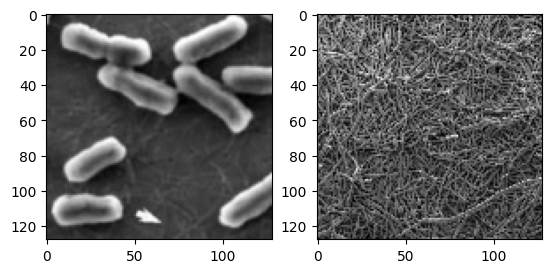

In [13]:
plt.subplot(121)
plt.imshow(test_images[1],cmap='gray')

plt.subplot(122)
plt.imshow(test_images[4],cmap='gray')

In [14]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded
x_train, x_test = x_train / 255.0, x_test / 255.0

In [15]:
print('x_train len', len(x_train))

x_train len 51


In [16]:
print('x_test len', len(x_test))

x_test len 6


In [25]:
def feature_extractor(dataset):
    x_train = dataset
    image_dataset = pd.DataFrame()
    for image in range(x_train.shape[0]):
        
        df = pd.DataFrame()
        input_img = x_train[image, :,:]
        img = input_img

        pixel_values = img.reshape(-1)
        df['Pixel_Value'] = pixel_values

        num = 1
        kernels = []
        for theta in range(2):
            theta = theta / 4. * np.pi
            for sigma in (1, 3):
                lamda = np.pi/4
                gamma = 0.5
                gabor_label = 'Gabor' + str(num)
                ksize=9
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)    
                kernels.append(kernel)

                fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img
                print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
                num += 1
                         
        edge_sobel = sobel(img)
        edge_sobel1 = edge_sobel.reshape(-1)
        df['Sobel'] = edge_sobel1

        image_dataset = pd.concat([image_dataset, df], ignore_index=True)
        
    return image_dataset

In [26]:
image_features = feature_extractor(x_train)

n_features = image_features.shape[1]
image_features = np.expand_dims(image_features, axis=0)
X_for_RF = np.reshape(image_features, (x_train.shape[0], -1))

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

In [27]:
test_features = feature_extractor(x_test)
test_features = np.expand_dims(test_features, axis=0)
test_for_RF = np.reshape(test_features, (x_test.shape[0], -1))

Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor2 : theta= 0.0 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor3 : theta= 0.7853981633974483 : sigma= 1 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor4 : theta= 0.7853981633974483 : sigma= 3 : lamda= 0.7853981633974483 : gamma= 0.5
Gabor1 : theta= 0.0 : sigma= 1 : lamda= 0.7853

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

RF_model = DecisionTreeClassifier()
RF_model.fit(X_for_RF, y_train)

test_prediction = RF_model.predict(test_for_RF)
test_prediction = le.inverse_transform(test_prediction)

from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, test_prediction))

Accuracy =  0.5


<AxesSubplot: >

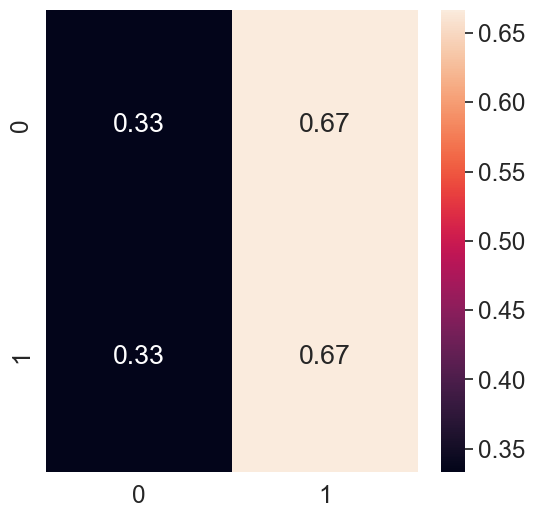

In [29]:
#Print confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_prediction)
cm = cm / cm.astype(np.float64).sum(axis=1)

fig, ax = plt.subplots(figsize=(6,6))         # Sample figsize in inches
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, ax=ax)

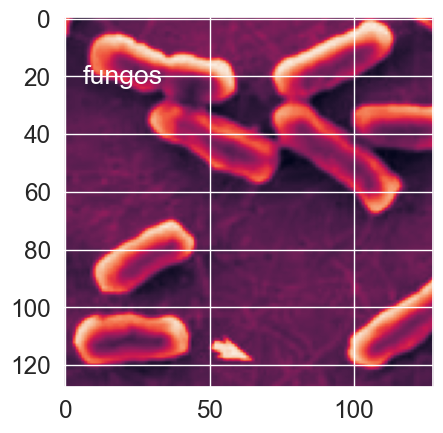

In [31]:
i = 1
plt.text(20, 20, test_prediction[i], dict(color='white', va='center', ha='center'))
plt.imshow(x_test[i])
plt.show()